In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Data Acquisition

## Scraping

In [35]:
def grab_epl_data():
    # Connect to football-data.co.uk
    res = requests.get("http://www.football-data.co.uk/englandm.php")

    # Create a BeautifulSoup object
    soup = BeautifulSoup(res.content, 'lxml')

    # Find the tables with the links to the data in them.
    table = soup.find_all('table', {'align': 'center', 'cellspacing': '0', 'width': '800'})[1]
    body = table.find_all('td', {'valign': 'top'})[1]
    print(table)
    # Grab the urls for the csv files
    links = [link.get('href') for link in body.find_all('a')]
    links_text = [link_text.text for link_text in body.find_all('a')]
#     print(links, links_text)
    data_urls = []

    # Create a list of links
    prefix = 'http://www.football-data.co.uk/'
    for i, text in enumerate(links_text):
        if text == 'Premier League':
            data_urls.append(prefix + links[i])
    
    # Get rid of last 11 uls as these don't include match stats and odds, and we
    # only want from 2005 onwards
    data_urls = data_urls[:-12]

    df = pd.DataFrame()

    # Iterate over the urls
    for url in data_urls:
        # Get the season and make it a column
        season = url.split('/')[4]

        print(f"Getting data for season {season}")

        # Read the data from the url into a DataFrame
        temp_df = pd.read_csv(url)
        temp_df['season'] = season

        # Create helpful columns like Day, Month, Year, Date etc. so that our data is clean
        temp_df = (temp_df.dropna(axis='columns', thresh=temp_df.shape[0]-30)
                          .assign(Day=lambda df: df.Date.str.split('/').str[0],
                                  Month=lambda df: df.Date.str.split('/').str[1],
                                  Year=lambda df: df.Date.str.split('/').str[2])
                          .assign(Date=lambda df: df.Month + '/' + df.Day + '/' + df.Year)
                          .assign(Date=lambda df: pd.to_datetime(df.Date))
                          .dropna())

        # Append the temp_df to the main df
        df = df.append(temp_df, sort=True)

    # Drop all NAs
#     df = df.dropna(axis=1).dropna().sort_values(by='Date')
    print("Finished grabbing data.")

    return df

## manually

In [4]:
df = pd.DataFrame()
for i in range(1,19):
    df = pd.concat([df, pd.read_csv(f"data/E0 ({i}).csv")])
    
df

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,...,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,SJH,SJD,SJA,GBH,GBD,GBA,BSH,BSD,BSA,SBH,SBD,SBA
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0.0,2.0,A,0.0,1.0,A,A Taylor,10.0,10.0,2.0,2.0,16.0,11.0,3.0,5.0,1.0,2.0,0.0,0.0,4.20,3.60,1.85,4.33,3.50,1.87,4.30,3.55,1.85,4.50,3.65,1.89,4.40,3.5,1.83,4.60,3.50,1.87,4.60,3.78,1.95,4.39,3.59,1.88,2.10,1.72,...,2.10,1.72,2.14,1.78,2.19,1.91,2.08,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,06/08/2022,12:30,Fulham,Liverpool,2.0,2.0,D,1.0,0.0,H,A Madley,9.0,11.0,3.0,4.0,7.0,9.0,4.0,4.0,2.0,0.0,0.0,0.0,11.00,6.00,1.25,10.00,5.75,1.28,12.00,5.75,1.27,11.20,6.22,1.28,12.00,5.5,1.27,13.00,6.00,1.25,13.00,6.40,1.31,10.99,6.05,1.28,1.50,2.62,...,1.50,2.62,1.49,2.77,1.51,3.00,1.47,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2.0,0.0,H,1.0,0.0,H,P Bankes,7.0,15.0,3.0,2.0,18.0,16.0,5.0,5.0,3.0,3.0,0.0,0.0,3.75,3.50,2.00,3.75,3.40,2.00,3.65,3.45,2.05,3.93,3.58,2.04,3.75,3.3,2.05,3.75,3.30,2.00,4.00,3.66,2.10,3.80,3.50,2.04,2.00,1.80,...,2.10,1.72,2.13,1.79,2.24,1.81,2.10,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,06/08/2022,15:00,Leeds,Wolves,2.0,1.0,H,1.0,1.0,D,R Jones,12.0,15.0,4.0,6.0,13.0,9.0,6.0,4.0,2.0,0.0,0.0,0.0,2.25,3.40,3.20,2.30,3.30,2.95,2.30,3.30,3.15,2.39,3.33,3.30,2.25,3.3,3.20,2.30,3.20,3.10,2.42,3.54,3.30,2.34,3.34,3.18,2.05,1.85,...,1.95,1.95,1.96,1.94,2.09,1.96,1.96,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2.0,0.0,H,0.0,0.0,D,S Hooper,23.0,5.0,10.0,0.0,9.0,14.0,11.0,1.0,0.0,3.0,0.0,0.0,1.66,3.80,5.25,1.65,3.80,5.50,1.65,3.80,5.50,1.71,3.74,5.83,1.67,3.7,5.25,1.62,3.70,5.50,1.72,3.96,6.00,1.67,3.80,5.57,2.05,1.85,...,1.94,1.96,1.97,1.93,2.06,1.97,1.94,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,07/05/06,NaN,Fulham,Middlesbrough,1.0,0.0,H,0.0,0.0,D,M Halsey,8.0,6.0,3.0,3.0,8.0,12.0,8.0,4.0,0.0,1.0,0.0,0.0,1.66,3.40,5.50,1.65,3.40,5.00,1.75,3.30,4.20,NaN,NaN,NaN,1.66,3.3,4.50,1.65,3.50,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,1.75,1.65,3.74,3.43,6.00,5.01,39.0,2.15,2.00,1.80,1.74,20.0,-0.75,1.88,1.81,2.10,2.05,1.57,3.25,5.50,1.73,3.4,4.33,1.7,3.5,4.80,NaN,NaN,NaN,1.7,3.40,5.00
376,E0,07/05/06,NaN,Man United,Charlton,4.0,0.0,H,3.0,0.0,H,M Atkinson,20.0,8.0,11.0,3.0,9.0,6.0,8.0,2.0,1.0,0.0,0.0,0.0,1.20,6.00,13.00,1.20,5.50,12.00,1.20,5.20,11.00,NaN,NaN,NaN,1.20,5.0,11.0

In [14]:
df_home = df.groupby(df['HomeTeam'])[stat_cols].mean()
df_home

,AC,AF,AR,AS,AST,AY,HC,HF,HR,HS,HST,HY,margin
HomeTeam,,,,,,,,,,,,,
Arsenal,4.002994,11.949102,0.116766,9.017964,3.790419,2.005988,7.224551,10.299401,0.059880,15.886228,7.440120,1.431138,1.200599
Aston Villa,5.705036,11.812950,0.100719,11.546763,5.359712,1.780576,5.971223,11.442446,0.064748,12.071942,5.208633,1.514388,-0.025180
Birmingham,5.723684,12.657895,0.052632,12.131579,5.960526,1.644737,5.644737,11.223684,0.092105,10.434211,5.171053,1.486842,0.118421
Blackburn,5.210526,12.308271,0.112782,10.894737,5.954887,1.849624,5.338346,13.639098,0.120301,12.375940,6.278195,1.699248,0.263158
Blackpool,6.473684,10.631579,0.157895,13.684211,8.000000,1.368421,4.947368,11.368421,0.000000,13.315789,7.052632,1.157895,-0.368421
Bolton,5.541353,11.947368,0.022556,11.571429,6.511278,1.601504,5.902256,12.661654,0.067669,12.857143,7.383459,1.421053,0.120301
Bournemouth,5.252336,11.990654,0.093458,13.065421,4.336449,1.934579,5.514019,9.420561,0.046729,12.233645,4.102804,1.626168,-0.149533
Brentford,5.451613,9.935484,0.064516,12.612903,4.451613,1.451613,4.548387,9.322581,0.064516,11.870968,4.354839,1.516129,0.451613
Brighton,4.330189,9.169811,0.037736,10.952830,3.849057,1.613208,5.773585,10.896226,0.047170,13.226415,3.867925,1.669811,-0.141509


In [15]:
df_away = df.groupby(df['AwayTeam']).mean()
df_away

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,...,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,SJH,SJD,SJA,GBH,GBD,GBA,BSH,BSD,BSA,SBH,SBD,SBA,margin
AwayTeam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arsenal,1.282738,1.592262,0.607143,0.729167,11.660714,12.613095,4.925595,5.642857,11.589286,10.226190,5.074405,5.226190,1.866071,1.708333,0.080357,0.113095,4.188839,3.774464,2.423690,4.040417,3.683274,2.387619,3.841851,3.586567,2.351403,3.998177,3.947783,2.610049,4.083313,3.594880,2.407078,4.195208,3.773333,2.449057,3.798714,4.070714,2.938000,3.597286,3.866429,2.775286,1.800714,2.089000,1.840714,2.144143,1.869857,2.206286,1.801857,2.097714,0.196429,1.950286,...,2.074143,1.869571,2.126714,1.917857,2.223714,1.832429,2.081286,0.221429,1.943286,1.965429,1.957857,1.971000,2.017429,2.023286,1.934000,1.950571,42.650376,4.630376,4.209211,3.908083,3.659286,2.466842,2.321654,36.868421,1.900038,1.808571,2.119850,2.007669,23.221805,0.375940,2.135489,2.048308,1.981917,1.917030,4.100040,3.594777,2.252874,4.294046,3.568324,2.245202,4.342895,3.530987,2.247961,4.325526,3.556842,2.308947,4.242361,3.481451,2.178278,-0.309524
Aston Villa,1.636691,1.140288,0.687050,0.517986,14.550360,10.165468,6.485612,4.622302,11.820144,12.197842,6.658273,4.884892,1.535971,1.996403,0.075540,0.061151,2.147374,3.920396,5.177986,2.106511,3.814604,4.821475,2.087806,3.710971,4.600072,2.026276,4.306138,6.111379,2.133796,3.699307,4.968139,2.150072,3.903777,5.260378,2.321159,4.337246,5.466667,2.234493,4.108116,4.946377,1.805652,2.117971,1.837681,2.193478,1.870435,2.228261,1.805797,2.129420,-0.492754,1.944493,...,2.144203,1.842464,2.214058,1.891159,2.294058,1.812754,2.148551,-0.489130,1.965362,1.942464,1.984058,1.951594,2.031304,2.005797,1.953333,1.933913,42.923445,2.226316,2.101675,4.036172,3.759617,5.791100,5.056986,35.928230,2.044115,1.934402,1.978660,1.874545,23.629808,-0.509615,2.008750,1.931202,2.123221,2.035096,2.085742,3.700191,4.900622,2.157746,3.676994,4.701387,2.220987,3.594474,4.469539,2.280351,3.599386,4.410702,2.226850,3.507368,4.178722,0.496403
Birmingham,1.828947,0.815789,0.828947,0.407895,14.921053,8.026316,8.539474,4.460526,12.105263,12.276316,6.473684,4.276316,1.078947,1.842105,0.065789,0.092105,1.829079,3.932632,6.478553,1.779211,3.830658,5.820395,1.825263,3.694079,5.159868,NaN,NaN,NaN,1.815286,3.676571,5.707571,1.824211,3.916579,6.352368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.921053,1.908684,1.820263,4.188421,3.843289,7.348158,6.074868,34.486842,2.101579,1.966316,1.916316,1.816974,22.513158,-0.480263,1.762368,1.709474,2.938421,2.689079,1.791184,3.761316,5.585658,1.813026,3.824605,5.920921,1.826184,3.830921,5.850658,1.806140,3.829123,6.153684,1.792895,3.798421,5.940000,1.013158
Blackburn,1.842105,1.067669,0.744361,0.466165,13.902256,9.338346,7.676692,5.105263,11.315789,12.924812,6.556391,4.827068,1.473684,2.052632,0.045113,0.135338,2.031654,3.771654,5.402857,1.952180,3.690226,5.080451,1.978271,3.546241,4.608271,NaN,NaN,NaN,1.977734,3.631641,5.101562,2.019782,3.810526,5.452331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.909774,2.135714,2.007368,3.981955,3.705263,6.161278,5.236842,35.045113,2.045714,1.925188,1.958797,1.853835,22.481203,-0.434211,1.858571,1.787143,2.511278,2.247068,1.972406,3.661128,4.942782,1.984962,3.718797,5.209098,2.013383,3.676165,4.996917,1.949263,3.738526,5.516632,1.975609,3.662481,4.91

# Feature Engineering

## Create HomeWin, Draw and AwayWin columns

In [70]:
# Create Home Win, Draw Win and Away Win columns
df = df.assign(homeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              awayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))

In [71]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,...,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,SJH,SJD,SJA,GBH,GBD,GBA,BSH,BSD,BSA,SBH,SBD,SBA,homeWin,draw,awayWin
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0.0,2.0,A,0.0,1.0,A,A Taylor,10.0,10.0,2.0,2.0,16.0,11.0,3.0,5.0,1.0,2.0,0.0,0.0,4.20,3.6,1.85,4.33,3.50,1.87,4.30,3.55,1.85,4.50,3.65,1.89,4.40,3.5,1.83,4.60,3.5,1.87,4.60,3.78,1.95,4.39,3.59,1.88,2.10,1.72,...,1.78,2.19,1.91,2.08,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
1,E0,06/08/2022,12:30,Fulham,Liverpool,2.0,2.0,D,1.0,0.0,H,A Madley,9.0,11.0,3.0,4.0,7.0,9.0,4.0,4.0,2.0,0.0,0.0,0.0,11.00,6.0,1.25,10.00,5.75,1.28,12.00,5.75,1.27,11.20,6.22,1.28,12.00,5.5,1.27,13.00,6.0,1.25,13.00,6.40,1.31,10.99,6.05,1.28,1.50,2.62,...,2.77,1.51,3.00,1.47,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2.0,0.0,H,1.0,0.0,H,P Bankes,7.0,15.0,3.0,2.0,18.0,16.0,5.0,5.0,3.0,3.0,0.0,0.0,3.75,3.5,2.00,3.75,3.40,2.00,3.65,3.45,2.05,3.93,3.58,2.04,3.75,3.3,2.05,3.75,3.3,2.00,4.00,3.66,2.10,3.80,3.50,2.04,2.00,1.80,...,1.79,2.24,1.81,2.10,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,E0,06/08/2022,15:00,Leeds,Wolves,2.0,1.0,H,1.0,1.0,D,R Jones,12.0,15.0,4.0,6.0,13.0,9.0,6.0,4.0,2.0,0.0,0.0,0.0,2.25,3.4,3.20,2.30,3.30,2.95,2.30,3.30,3.15,2.39,3.33,3.30,2.25,3.3,3.20,2.30,3.2,3.10,2.42,3.54,3.30,2.34,3.34,3.18,2.05,1.85,...,1.94,2.09,1.96,1.96,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2.0,0.0,H,0.0,0.0,D,S Hooper,23.0,5.0,10.0,0.0,9.0,14.0,11.0,1.0,0.0,3.0,0.0,0.0,1.66,3.8,5.25,1.65,3.80,5.50,1.65,3.80,5.50,1.71,3.74,5.83,1.67,3.7,5.25,1.62,3.7,5.50,1.72,3.96,6.00,1.67,3.80,5.57,2.05,1.85,...,1.93,2.06,1.97,1.94,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


## Create 'Margin' Column for Target

In [9]:
# This Column focusses on the Home team margin
df['margin'] = df['FTHG'] - df['FTAG']
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,...,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA,SJH,SJD,SJA,GBH,GBD,GBA,BSH,BSD,BSA,SBH,SBD,SBA,margin
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0.0,2.0,A,0.0,1.0,A,A Taylor,10.0,10.0,2.0,2.0,16.0,11.0,3.0,5.0,1.0,2.0,0.0,0.0,4.20,3.6,1.85,4.33,3.50,1.87,4.30,3.55,1.85,4.50,3.65,1.89,4.40,3.5,1.83,4.60,3.5,1.87,4.60,3.78,1.95,4.39,3.59,1.88,2.10,1.72,...,1.72,2.14,1.78,2.19,1.91,2.08,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0
1,E0,06/08/2022,12:30,Fulham,Liverpool,2.0,2.0,D,1.0,0.0,H,A Madley,9.0,11.0,3.0,4.0,7.0,9.0,4.0,4.0,2.0,0.0,0.0,0.0,11.00,6.0,1.25,10.00,5.75,1.28,12.00,5.75,1.27,11.20,6.22,1.28,12.00,5.5,1.27,13.00,6.0,1.25,13.00,6.40,1.31,10.99,6.05,1.28,1.50,2.62,...,2.62,1.49,2.77,1.51,3.00,1.47,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2.0,0.0,H,1.0,0.0,H,P Bankes,7.0,15.0,3.0,2.0,18.0,16.0,5.0,5.0,3.0,3.0,0.0,0.0,3.75,3.5,2.00,3.75,3.40,2.00,3.65,3.45,2.05,3.93,3.58,2.04,3.75,3.3,2.05,3.75,3.3,2.00,4.00,3.66,2.10,3.80,3.50,2.04,2.00,1.80,...,1.72,2.13,1.79,2.24,1.81,2.10,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,E0,06/08/2022,15:00,Leeds,Wolves,2.0,1.0,H,1.0,1.0,D,R Jones,12.0,15.0,4.0,6.0,13.0,9.0,6.0,4.0,2.0,0.0,0.0,0.0,2.25,3.4,3.20,2.30,3.30,2.95,2.30,3.30,3.15,2.39,3.33,3.30,2.25,3.3,3.20,2.30,3.2,3.10,2.42,3.54,3.30,2.34,3.34,3.18,2.05,1.85,...,1.95,1.96,1.94,2.09,1.96,1.96,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2.0,0.0,H,0.0,0.0,D,S Hooper,23.0,5.0,10.0,0.0,9.0,14.0,11.0,1.0,0.0,3.0,0.0,0.0,1.66,3.8,5.25,1.65,3.80,5.50,1.65,3.80,5.50,1.71,3.74,5.83,1.67,3.7,5.25,1.62,3.7,5.50,1.72,3.96,6.00,1.67,3.80,5.57,2.05,1.85,...,1.96,1.97,1.93,2.06,1.97,1.94,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


### Calculate correlation between stats columns and the target

In [7]:
stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTR', 'HY', 'margin']

stat_correlations = df[stat_cols].corr()
stat_correlations['margin'].sort_values()

KeyError: "['margin'] not in index"

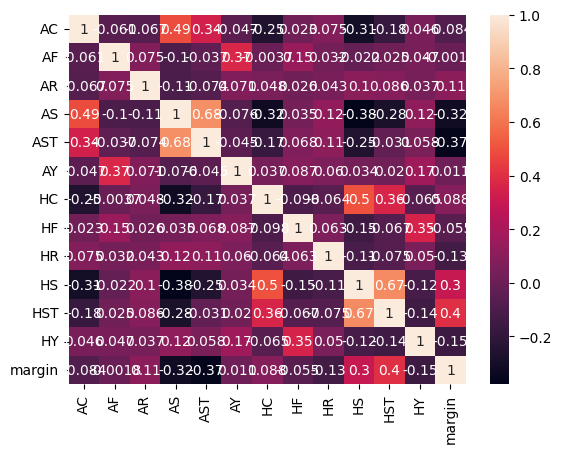

In [81]:
sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 10});

In [84]:
print(df.columns.values)

['Div' 'Date' 'Time' 'HomeTeam' 'AwayTeam' 'FTHG' 'FTAG' 'FTR' 'HTHG'
 'HTAG' 'HTR' 'Referee' 'HS' 'AS' 'HST' 'AST' 'HF' 'AF' 'HC' 'AC' 'HY'
 'AY' 'HR' 'AR' 'B365H' 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH' 'IWD'
 'IWA' 'PSH' 'PSD' 'PSA' 'WHH' 'WHD' 'WHA' 'VCH' 'VCD' 'VCA' 'MaxH' 'MaxD'
 'MaxA' 'AvgH' 'AvgD' 'AvgA' 'B365>2.5' 'B365<2.5' 'P>2.5' 'P<2.5'
 'Max>2.5' 'Max<2.5' 'Avg>2.5' 'Avg<2.5' 'AHh' 'B365AHH' 'B365AHA' 'PAHH'
 'PAHA' 'MaxAHH' 'MaxAHA' 'AvgAHH' 'AvgAHA' 'B365CH' 'B365CD' 'B365CA'
 'BWCH' 'BWCD' 'BWCA' 'IWCH' 'IWCD' 'IWCA' 'PSCH' 'PSCD' 'PSCA' 'WHCH'
 'WHCD' 'WHCA' 'VCCH' 'VCCD' 'VCCA' 'MaxCH' 'MaxCD' 'MaxCA' 'AvgCH'
 'AvgCD' 'AvgCA' 'B365C>2.5' 'B365C<2.5' 'PC>2.5' 'PC<2.5' 'MaxC>2.5'
 'MaxC<2.5' 'AvgC>2.5' 'AvgC<2.5' 'AHCh' 'B365CAHH' 'B365CAHA' 'PCAHH'
 'PCAHA' 'MaxCAHH' 'MaxCAHA' 'AvgCAHH' 'AvgCAHA' 'Bb1X2' 'BbMxH' 'BbAvH'
 'BbMxD' 'BbAvD' 'BbMxA' 'BbAvA' 'BbOU' 'BbMx>2.5' 'BbAv>2.5' 'BbMx<2.5'
 'BbAv<2.5' 'BbAH' 'BbAHh' 'BbMxAHH' 'BbAvAHH' 'BbMxAHA' 'BbAvAHA' 'LBH'
 'L

In [88]:
df_results = df[['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG','HTAG', 'HTR', 'Referee', 'homeWin', 'draw', 'awayWin']]
df_results.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,homeWin,draw,awayWin
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0.0,2.0,A,0.0,1.0,A,A Taylor,0,0,1
1,E0,06/08/2022,12:30,Fulham,Liverpool,2.0,2.0,D,1.0,0.0,H,A Madley,0,1,0
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2.0,0.0,H,1.0,0.0,H,P Bankes,1,0,0
3,E0,06/08/2022,15:00,Leeds,Wolves,2.0,1.0,H,1.0,1.0,D,R Jones,1,0,0
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2.0,0.0,H,0.0,0.0,D,S Hooper,1,0,0


In [87]:
df_stats=df[stat_cols]
df_stats.head()

,AC,AF,AR,AS,AST,AY,HC,HF,HR,HS,HST,HTR,HY,margin
0,5.0,11.0,0.0,10.0,2.0,2.0,3.0,16.0,0.0,10.0,2.0,A,1.0,-2.0
1,4.0,9.0,0.0,11.0,4.0,0.0,4.0,7.0,0.0,9.0,3.0,H,2.0,0.0
2,5.0,16.0,0.0,15.0,2.0,3.0,5.0,18.0,0.0,7.0,3.0,H,3.0,2.0
3,4.0,9.0,0.0,15.0,6.0,0.0,6.0,13.0,0.0,12.0,4.0,D,2.0,1.0
4,1.0,14.0,0.0,5.0,0.0,3.0,11.0,9.0,0.0,23.0,10.0,D,0.0,2.0


In [90]:
df_odds = df[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD',\
'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA',]]
df_odds.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA
0,4.20,3.6,1.85,4.33,3.50,1.87,4.30,3.55,1.85,4.50,3.65,1.89,4.40,3.5,1.83,4.60,3.5,1.87
1,11.00,6.0,1.25,10.00,5.75,1.28,12.00,5.75,1.27,11.20,6.22,1.28,12.00,5.5,1.27,13.00,6.0,1.25
2,3.75,3.5,2.00,3.75,3.40,2.00,3.65,3.45,2.05,3.93,3.58,2.04,3.75,3.3,2.05,3.75,3.3,2.00
3,2.25,3.4,3.20,2.30,3.30,2.95,2.30,3.30,3.15,2.39,3.33,3.30,2.25,3.3,3.20,2.30,3.2,3.10
4,1.66,3.8,5.25,1.65,3.80,5.50,1.65,3.80,5.50,1.71,3.74,5.83,1.67,3.7,5.25,1.62,3.7,5.50
